## BPZ Tests

## Roman Filter Transmission Data

In [1]:
import astropy.units as u
from astropy.constants import c, h
import pandas as pd
import numpy as np
from synphot import units, SourceSpectrum, SpectralElement, Observation
from synphot.models import Empirical1D
from tqdm import tqdm
from scipy.integrate import quad, odeint
import os
import desc_bpz
import matplotlib.pyplot as plt

current_dir, _ = os.path.split("__file__")

bpz_dir, _ = os.path.split(desc_bpz.__file__)
sed_dir = os.path.join(bpz_dir, "data_files", "SED")

z_range = np.linspace(start=0.005, stop=3.505, num=int(3.5/0.01))
verbose = False


In [3]:
def load_filters() -> pd.DataFrame:
    """Loads filter transmission profiles

    Parameters
    ----------
    None

    Returns
    -------
    filters: pandas.DataFrame
        Filter transmission profiles as a function of wavelength
    """
    global current_dir
    filters = pd.read_excel(os.path.join(current_dir, "data_files", "FILTER", "Roman_effarea_20210614.xlsx"), skiprows=1)
    filters.columns = [column.strip() for column in filters.columns]
    if filters["Wave"][0] == 0:
        filters.drop(0, inplace=True)
    filters.drop(columns=["SNPrism", "Grism_1stOrder", "Grism_0thOrder"], inplace=True)
    filters["Wave"] *= 10000 # micron to angstrom conversion
    filters[filters.columns.drop("Wave")] /= np.pi * 1.2**2 # effective area to throughput conversion
    return filters

def spectral(wavelengths: np.ndarray) -> np.ndarray:
    """Converts wavelengths of arbitrary units into frequencies in units Hertz (Hz)

    Parameters
    ----------
    wavelenths: stropy.unit.quantity.Quantity
        Wavelengths of arbitrary units

    Returns
    -------
    frequencies: astropy.unit.quantity.Quantity
        Frequencies in units of Hertz (Hz)
    
    """
    frequencies = (wavelengths).to(u.Hz, equivalencies=u.spectral())
    return frequencies

    # filter_data = []
    # filter_ids = []
    # for filter_file in tqdm(sorted([f for f in os.listdir(filter_dir) if "RST" in f]),
    #                         desc="Loading filter transmission profiles:",
    #                         disable=(not args.verbose), position=0):
    #     filter_ids.append(int(filter_file[filter_file.find("_")+2:filter_file.find(".")]))
    #     filter_data.append(SpectralElement.from_file(os.path.join(filter_dir, filter_file), data_start=1))
    


In [5]:
def flux(transmission, limits, sed=None):
    return quad(lambda f: transmission(f).value * (sed(f).value if sed else 3631) / (h.value  * f), *limits)[0]

In [4]:
def magnitude(sed: SourceSpectrum, transmission: SpectralElement, limits=list[float]) -> float:
    """Calculates AB calibrated magnitude 

    Parameters
    ----------
    sed: synphot.units.SourceSpectrum
        Spectral energy distribution

    transmission: synphot.units.SpectralElement
        Transmission profile for a particular filter

    limits: list[float]
        Frequency limits for flux integration
    
    Returns
    -------
    m_AB: float
        AB calibrated magnitude
    """
    # observed_flux = quad(lambda f: transmission_profile(f).value * 3631 / (h.value  * f), a, b)[0]
    # reference_flux = quad(lambda f: transmission_profile(f).value * sed(f).value / (h.value * f), a, b)[0]
    # m_AB = 2.5*np.log10(observed_flux/reference_flux
    return 2.5*np.log10(flux(transmission, limits, sed)/flux(transmission, limits)) # m_AB

In [6]:
def show_magnitudes(filter_ids):
    with open("magnitue_data.npy", "rb") as f: 
        magnitudes = np.load(f)
        print(magnitudes.shape)
    for i, sed_file in enumerate([os.path.split(sed_file)[1].rsplit('_', 1)[0] for sed_file in os.listdir(sed_dir) if "CWWSB4" not in sed_file]):
        print(sed_file)
        colors = ["red", "brown", "orange", "yellow", "green", "blue", "indigo", "darkviolet"]
        fig, ax = plt.subplots(figsize=(10,10))
        count = 0
        for j, (color, filter_id) in enumerate(zip(colors, filter_ids)):
            ax.plot(z_range, magnitudes[i,:,j], '-', color=color, label=f"{filter_id}")
        ax.set_xlabel("Redshift (z)")
        ax.set_ylabel("AB Magnitude")
        ax.set_title(f"{sed_file} Galaxy AB Magnitude vs. Redshift (z)")
        ax.legend()
        plt.rcParams["axes.facecolor"]='white'
        plt.rcParams["savefig.facecolor"]='white'
        plt.rcParams["figure.facecolor"] = 'white' 
        plt.savefig(f"data_files/{sed_file}_magnitude.png")
        plt.show()

def get_transmission_profiles():
    filter_data = load_filters()
    filter_ids = filter_data.columns.drop("Wave")
    transmission_profiles, bounds = [], []
    frequencies = spectral(filter_data["Wave"].to_numpy()*u.AA)
    for filter_id in filter_ids:
        transmission_profiles.append(SpectralElement(Empirical1D, points=frequencies, lookup_table=filter_data[filter_id].to_numpy()))
        valid_indx = np.argwhere(filter_data[filter_id] > 0).flatten()
        bounds.append([np.min(filter_data["Wave"][valid_indx]), np.max(filter_data["Wave"][valid_indx])])
        assert(bounds[-1][0]<bounds[-1][1])
    
    return filter_ids, transmission_profiles, bounds

def get_magnitudes(transmission_profiles, bounds):
    """
    Parameters
    ----------
    transmission_profiles: 

    integration

    Returns
    -------
    """
    magnitudes = np.empty((8, len(z_range), len(transmission_profiles)))
    for i, sed_file in enumerate([sed_file for sed_file in os.listdir(sed_dir) if "CWWSB4" not in sed_file]):
        galaxy_type = sed_file.rsplit('_', 1)[0]
        wavelength, flux = np.loadtxt(os.path.join(sed_dir, sed_file)).T # Angstrom, nJy
        if wavelength[0] == 0:
            wavelength, flux = wavelength[1:], flux[1:]
        frequencies, flux = spectral(wavelength*u.AA), flux*1e-9*u.Jy
        for j, z in enumerate(tqdm(z_range, desc=f"Redshifts for {galaxy_type} Type Galaxy")):
            for k, (transmission, limit) in enumerate(zip(transmission_profiles, bounds)):
                magnitudes[i][j][k] = magnitude(SourceSpectrum(Empirical1D, points=frequencies, lookup_table=flux, z=z, z_type="conserve_flux"), transmission, *limit)
        with open("magnitue_data.npy", "wb") as f:
            np.save(f, magnitudes)
            print(f"saving {galaxy_type}")

    return magnitudes

In [7]:
def main():
    filter_ids, transmission_profiles, bounds = get_transmission_profiles()
    _ = get_magnitudes(transmission_profiles, bounds)
    show_magnitudes(filter_ids)



In [1]:
import numpy as np
from scipy.integrate import quad, odeint
import quadpy

def test(a, b):
    return quadpy.quad(lambda x: np.square(x), a, b)

def test2(a, b):
    return odeint(lambda y, x: np.square(x), a, b)

a = np.linspace(1, 10, 10)
b = a+1

result = test(a, b)
result 
# for i, b in enumerate(bb):
#     result[i] = test(a, b)[0]
print(result)

Error: Unable to find valid license for Sigma. 

Add a license with

    plm add <your-license-key>

AttributeError: 'tuple' object has no attribute 'tb_frame'

In [ ]:
filters = pd.read_excel("https://roman.gsfc.nasa.gov/science/RRI/Roman_effarea_20210614.xlsx", skiprows=1)
filters.columns = [column.strip() for column in filters.columns]
filters.drop(columns=["SNPrism", "Grism_1stOrder", "Grism_0thOrder"], inplace=True)
filters[filters.columns.drop("Wave")] /= np.pi * 1.2**2 # converts effective area to throughput
filters["Wave"] = (filters["Wave"]*10000).astype(int) # μm to Å

# for filter in [filters[["Wave", filter_id]] for filter_id in filters.columns.drop("Wave")]:
#     save_txt

In [20]:
from os.path import abspath, expanduser
import pandas as pd
import numpy as np

files = ["zphot_vista_adapt", "zphot_vista_shift", "zphot_vista_noline", "zphot_vista_noadapt", "zphot_vista_select", "masses", "magabs"]
for file in files:
    path = abspath(expanduser(f"~/code/LEPHARE/examples/{file}.out"))
    if os.path.isfile(path):
        print(path)
        arr = np.loadtxt(path)
        print(arr.shape)




/Users/allake/code/LEPHARE/examples/zphot_vista_adapt.out
(4930, 151)
/Users/allake/code/LEPHARE/examples/zphot_vista_shift.out
(2705, 238)


In [49]:
columns = "Z_BEST  Z_BEST68_LOW  Z_BEST68_HIGH  Z_ML  Z_ML68_LOW  Z_ML68_HIGH  CHI_BEST  MOD_BEST  EXTLAW_BEST  EBV_BEST  Z_SEC  CHI_SEC  MOD_SEC  EBV_SEC  Z_QSO  CHI_QSO  MOD_QSO  MOD_STAR  CHI_STAR  MAG_OBS0  MAG_OBS1  MAG_OBS2  MAG_OBS3  MAG_OBS4  MAG_OBS5  MAG_OBS6  MAG_OBS7  ERR_MAG_OBS0  ERR_MAG_OBS1  ERR_MAG_OBS2  ERR_MAG_OBS3  ERR_MAG_OBS4  ERR_MAG_OBS5  ERR_MAG_OBS6  ERR_MAG_OBS7  K_COR0  K_COR1  K_COR2  K_COR3  K_COR4  K_COR5  K_COR6  K_COR7  MAG_ABS0  MAG_ABS1  MAG_ABS2  MAG_ABS3  MAG_ABS4  MAG_ABS5  MAG_ABS6  MAG_ABS7  EMAG_ABS0  EMAG_ABS1  EMAG_ABS2  EMAG_ABS3  EMAG_ABS4  EMAG_ABS5  EMAG_ABS6  EMAG_ABS7  MABS_FILT0  MABS_FILT1  MABS_FILT2  MABS_FILT3  MABS_FILT4  MABS_FILT5  MABS_FILT6  MABS_FILT7  SCALE_BEST  NBAND_USED  CONTEXT  ZSPEC  AGE_BEST  AGE_INF  AGE_MED  AGE_SUP  LDUST_BEST  LDUST_INF  LDUST_MED  LDUST_SUP  LUM_TIR_BEST  LUM_TIR_INF  LUM_TIR_MED  LUM_TIR_SUP  MASS_BEST  MASS_INF  MASS_MED  MASS_SUP  SFR_BEST  SFR_INF  SFR_MED  SFR_SUP  SSFR_BEST  SSFR_INF  SSFR_MED  SSFR_SUP  COL1_INF  COL1_MED  COL1_SUP  COL2_INF  COL2_MED  COL2_SUP  LUM_NUV_BEST  LUM_R_BEST  LUM_K_BEST"
columns = columns.split()
print(len(columns))
path = abspath(expanduser("~/code/LEPHARE/examples/zphot_vista_adapt.out"))
df = pd.DataFrame(columns=columns)
with open(path, "r") as f:
    lines = f.readlines()[49:]
    for i, line in enumerate(lines):
        df.loc[i] = line.split()[1:len(columns)+1]

104


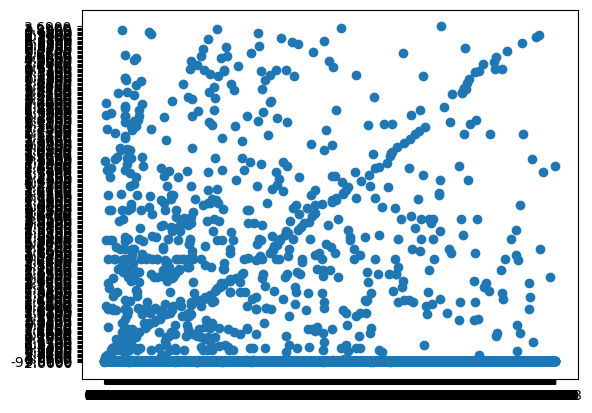

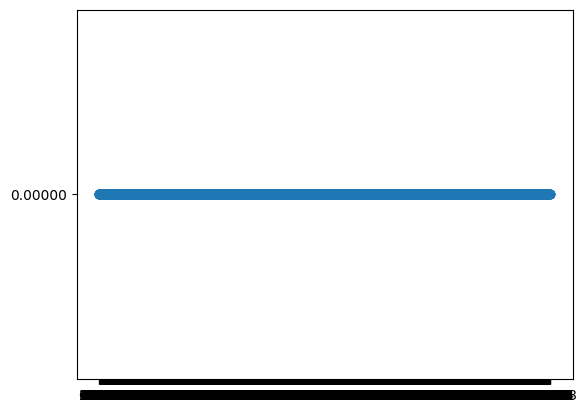

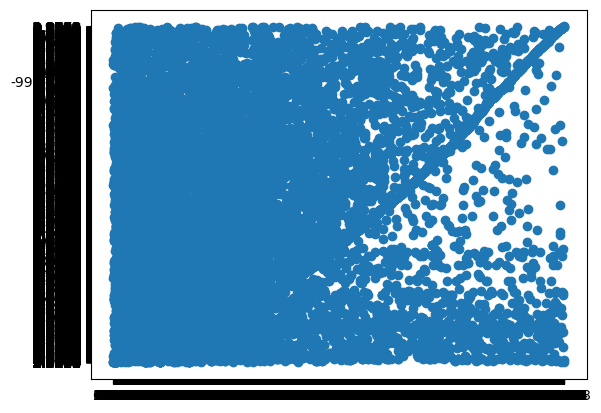

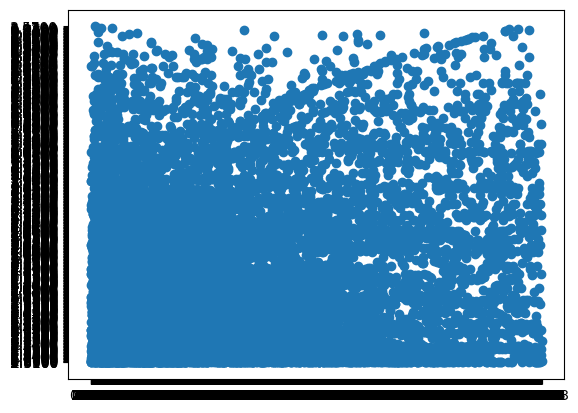

In [55]:
import matplotlib.pyplot as plt
for z_type in ["Z_SEC", "ZSPEC", "Z_ML", "Z_QSO"]:
    fig, ax = plt.subplots()
    ax.scatter(df["Z_BEST"], df[z_type])
    plt.show()
    plt.close(fig)

In [48]:
print(df.loc[len(df.index)-1])

Z_BEST                13480
Z_BEST68_LOW         0.4834
Z_BEST68_HIGH        0.4799
Z_ML                 0.4804
Z_ML68_LOW           0.4800
                    ...    
COL2_MED         -999.00000
COL2_SUP         -999.00000
LUM_NUV_BEST     -999.00000
LUM_R_BEST           10.091
LUM_K_BEST           10.475
Name: 13479, Length: 104, dtype: object
